In [83]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.time import Time
from astropy.coordinates import SkyCoord
from lsst.rsp import get_tap_service


# Calexp from visits in a time interval

In this notebook we gather calexps over a region of the sky and a time interval. The goal is to write code that can fetch the right images from a sky region with size representative of the high-energy telescope uncertainties, over a period relevant to KN searches. For this reason we will consider error radius $\sim 3 \text{ deg}$ which we found is the median Fermi-GBM localization error, and timespans of about 1 week. Then, we study the count frequency of these images to get a sense of the amount of data we are going to face.

First we select a sky coordinate in the wide-fast-deep field of dp0.dc2 simulation with appropriate uncertainty.

In [84]:
target = SkyCoord('55.745834deg', '-32.269167deg', frame='icrs') 

ra_deg = target.ra.deg
dec_deg = target.dec.deg
err_radius_deg = 3.

In [85]:
target

<SkyCoord (ICRS): (ra, dec) in deg
    (55.745834, -32.269167)>

# The visit table

We look around the database and fetch the visit table.

In [86]:
service = get_tap_service("tap")

In [124]:
def query_and_table(service, query):
    return service.search(query).to_table()

query_and_table(service, "SELECT * FROM tap_schema.schemas")

description,schema_index,schema_name,utype
object,int32,object,object
"Data Preview 0.2 contains the image and catalog products of the Rubin Science Pipelines v23 processing of the DESC Data Challenge 2 simulation, which covered 300 square degrees of the wide-fast-deep LSST survey region over 5 years.",0,dp02_dc2_catalogs,
ObsCore v1.1 attributes in ObsTAP realization,1,ivoa,
A TAP-standard-mandated schema to describe tablesets in a TAP 1.1 service,100000,tap_schema,


In [88]:
query_and_table(
    service,
    "SELECT * "
    "FROM tap_schema.tables "
    "WHERE tap_schema.tables.schema_name = 'dp02_dc2_catalogs'"
)

description,schema_name,table_index,table_name,table_type,utype
object,object,int32,object,object,object
Metadata about the 189 individual CCD images for each Visit in the DC2 simulated survey.,dp02_dc2_catalogs,8,dp02_dc2_catalogs.CcdVisit,table,
Static information about the subset of tracts and patches from the standard LSST skymap that apply to coadds in these catalogs,dp02_dc2_catalogs,9,dp02_dc2_catalogs.CoaddPatches,table,
Properties of time-varying astronomical objects based on association of data from one or more spatially-related DiaSource detections on individual single-epoch difference images.,dp02_dc2_catalogs,4,dp02_dc2_catalogs.DiaObject,table,
Properties of transient-object detections on the single-epoch difference images.,dp02_dc2_catalogs,5,dp02_dc2_catalogs.DiaSource,table,
"Forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the Object table. Point-source PSF photometry is performed, based on coordinates from a reference band chosen for each Object and reported in the Object.refBand column.",dp02_dc2_catalogs,3,dp02_dc2_catalogs.ForcedSource,table,
"Point-source forced-photometry measurements on individual single-epoch visit images and difference images, based on and linked to the entries in the DiaObject table.",dp02_dc2_catalogs,6,dp02_dc2_catalogs.ForcedSourceOnDiaObject,table,
Match information for TruthSummary objects.,dp02_dc2_catalogs,11,dp02_dc2_catalogs.MatchesTruth,table,
Properties of the astronomical objects detected and measured on the deep coadded images.,dp02_dc2_catalogs,1,dp02_dc2_catalogs.Object,table,
"Properties of detections on the single-epoch visit images, performed independently of the Object detections on coadded images.",dp02_dc2_catalogs,2,dp02_dc2_catalogs.Source,table,


In [89]:
query_and_table(
    service,
    "SELECT column_name, datatype, description, unit "
    "FROM tap_schema.columns "
    "WHERE table_name = 'dp02_dc2_catalogs.Visit'"
)

column_name,datatype,description,unit
object,object,object,object
airmass,double,Airmass of the observed line of sight.,
altitude,double,Altitude of focal plane center at the middle of the exposure.,deg
azimuth,double,Azimuth of focal plane center at the middle of the exposure.,deg
band,char,Name of the band used to take the exposure where this source was measured. Abstract filter that is not associated with a particular instrument.,
decl,double,Declination of focal plane center,deg
expMidpt,char,"Midpoint time for exposure at the fiducial center of the focal plane array. TAI, accurate to 10ms.",
expMidptMJD,double,"Midpoint time for exposure at the fiducial center of the focal plane array in MJD. TAI, accurate to 10ms.",d
expTime,double,"Spatially-averaged duration of exposure, accurate to 10ms.",s
obsStart,char,"Start time of the exposure at the fiducial center of the focal plane array, TAI, accurate to 10ms.",


Here it is! The data we are looking for. First we convert the table to a pandas dataframe. 

In [90]:
visits_df = query_and_table(
    service,
    "SELECT * " 
    "FROM dp02_dc2_catalogs.Visit"
).to_pandas()
visits_df.head()

,airmass,altitude,azimuth,band,decl,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,physical_filter,ra,skyRotation,visit,zenithDistance
0,1.097656,65.364165,128.492828,g,-42.998764,2022-08-26T07:54:20.697800,59817.329406,30.0,2022-08-26T07:54:05.697800,59817.329233,g_sim_1.4,48.816726,55.305716,178142,24.635835
1,1.073027,68.495289,134.109077,g,-43.554762,2022-08-28T08:05:01.699100,59819.336825,30.0,2022-08-28T08:04:46.699100,59819.336652,g_sim_1.4,48.268655,52.942898,180090,21.504711
2,1.049297,72.147000,143.553058,g,-43.826917,2022-08-28T08:35:56.880,59819.358297,30.0,2022-08-28T08:35:41.880,59819.358124,g_sim_1.4,49.346433,69.782977,180134,17.853000
3,1.043240,73.291392,137.300217,g,-41.679127,2022-08-28T08:36:40.252900,59819.358799,30.0,2022-08-28T08:36:25.252900,59819.358626,g_sim_1.4,50.037170,62.769883,180135,16.708608
4,1.173574,58.011960,120.956971,g,-41.499734,2022-09-01T07:01:36.729800,59823.292786,30.0,2022-09-01T07:01:21.729800,59823.292613,g_sim_1.4,52.358132,358.191446,183780,31.988040


Now we look the date range spanned by the simulation so that we can define sensible values for our initial and final times.

In [91]:
visits_df["obsStart"] = pd.to_datetime(visits_df["obsStart"], format="ISO8601")
visits_df["obsStart"].describe()

count                            19840
mean     2024-11-11 10:02:50.569529088
min         2022-01-03 00:59:36.321800
25%      2023-09-29 05:33:09.448774912
50%      2024-11-12 02:12:35.419350016
75%      2025-12-08 05:44:15.830450176
max         2027-01-01 01:01:50.587100
Name: obsStart, dtype: object

This is a histogram of the visit count over two years. I was expecting something more regular?  

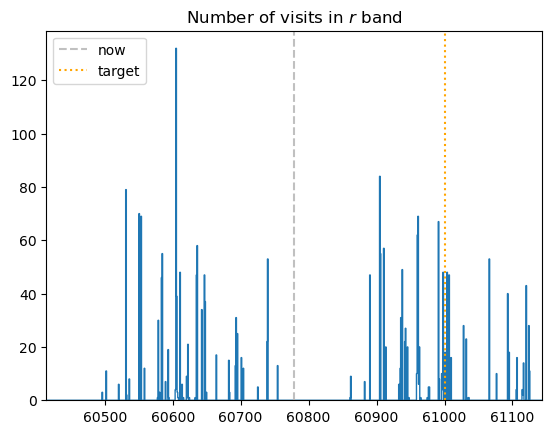

In [100]:
_t =datetime.fromisoformat("2025-04-24") - timedelta(days=10)
counts, bins = np.histogram(visits_df[visits_df["band"] == "r"]["obsStartMJD"], bins=365*5)

plt.stairs(counts, bins)
plt.axvline(Time(_t).to_value("mjd"), label="now", ls="dashed", c='silver')
plt.axvline(61_000, ls="dotted", label="target", c='orange')
plt.xlim(
    Time(_t - timedelta(days=365)).to_value("mjd"),
    Time(_t + timedelta(days=365)).to_value("mjd"),
)
plt.title("Number of visits in $r$ band")
plt.legend()


Let's try to catch a week with some observations in $r$ band.. The one around MJD61000 will do.

In [101]:
stop_dt = datetime.fromisoformat(Time(61_000, format="mjd").to_value("iso"))
start_dt = stop_dt - timedelta(days=7)

start_mj, stop_mj = map(lambda x: Time(x).to_value("mjd"), (start_dt, stop_dt,))

In [102]:
visits_selected_df = visits_df[
    (visits_df["band"] == "r") & 
    (visits_df["obsStart"] >= start_dt) & 
    (visits_df["obsStart"] < stop_dt)
]
visits_selected_df.head()

,airmass,altitude,azimuth,band,decl,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,physical_filter,ra,skyRotation,visit,zenithDistance
7073,1.120245,62.875231,129.962351,r,-44.529077,2025-11-19T02:22:31.200,60998.098972,30.0,2025-11-19 02:22:16.200000,60998.098799,r_sim_1.4,52.546068,26.299480,963955,27.124769
7074,1.087636,66.574136,133.582713,r,-44.342751,2025-11-19T02:42:36.739100,60998.112925,30.0,2025-11-19 02:42:21.739100,60998.112752,r_sim_1.4,51.975625,28.422380,963986,23.425864
7075,1.031223,75.722882,146.199781,r,-41.695514,2025-11-19T03:40:31.747100,60998.153145,30.0,2025-11-19 03:40:16.747100,60998.152972,r_sim_1.4,53.335714,34.196664,964074,14.277118
7232,1.139306,61.011414,126.137406,r,-43.431519,2025-11-19T02:21:52.406200,60998.098523,30.0,2025-11-19 02:21:37.406200,60998.098350,r_sim_1.4,55.643971,20.928957,963954,28.988586
7233,1.071889,68.659190,136.471197,r,-44.194011,2025-11-19T03:12:45.004900,60998.133854,30.0,2025-11-19 03:12:30.004900,60998.133681,r_sim_1.4,56.245742,25.993732,964032,21.340810


# The image table

Let's give a look to the columns of the `ivoa.ObsCore` table. This table contains infos about the images in the DP0.DC2 dataset.

In [104]:
query_and_table(
    "SELECT column_name, datatype, description, unit "
    "FROM tap_schema.columns "
    "WHERE table_name = 'ivoa.ObsCore'"
).to_pandas()

,column_name,datatype,description,unit
0,access_format,char,Content format of the dataset,
1,access_url,char,URL used to access dataset,
2,calib_level,int,"Calibration level of the observation: in {0, 1...",
3,dataproduct_subtype,char,Data product specific type,
4,dataproduct_type,char,Data product (file content) primary type,
5,em_max,double,stop in spectral coordinates,m
6,em_min,double,start in spectral coordinates,m
7,em_res_power,double,Value of the resolving power along the spectra...,
8,em_xel,long,Number of elements along the spectral axis,
9,facility_name,char,"The name of the facility, telescope, or space ...",


We query for the calexp in the time and space domain just defined.

In [130]:
def circle_string(ra, dec, err_radius):
    return f"{ra:.4f}, {dec:.4f}, {err_radius:.4f}"


def query_obs_stdomain(service, tstart_mj, tstop_mj, ra, dec, err_radius, dp_subtype="lsst.calexp"):
    """
    Queries observation table for all pictures of type `dp_subtype` taken between 
    start_mj and stop_mj, with central spatial position falling in a circle centered
    at `ra`, `dec` with radius `err_radius`.
    """
    return query_and_table(
        service, 
        "SELECT *"
        "FROM ivoa.ObsCore "
        f"WHERE CONTAINS(POINT('ICRS', s_ra, s_dec), CIRCLE('ICRS', {circle_string(ra, dec, err_radius)}))=1 "
        f"AND t_min >= {tstart_mj} "
        f"AND t_min < {tstop_mj} "
        f"AND dataproduct_subtype = '{dp_subtype}'"
    ).to_pandas()

In [131]:
images_table = query_obs_stdomain(service, start_mj, stop_mj, ra_deg, dec_deg, err_radius_deg)

The subtable we got back is quite big. This is an excerpt:

In [133]:
images_table[["lsst_visit", "lsst_detector", "lsst_band", "t_min", "s_dec", "s_ra", "s_fov", "t_exptime"]]

,lsst_visit,lsst_detector,lsst_band,t_min,s_dec,s_ra,s_fov,t_exptime
0,961642,6,u,60995.068865,-31.839292,58.792309,0.356269,30.0
1,960249,43,g,60993.128154,-31.476183,57.566593,0.356352,30.0
2,961642,54,u,60995.068865,-31.928688,57.110348,0.356328,30.0
3,960204,35,g,60993.107927,-33.686823,56.968216,0.356294,30.0
4,963256,48,r,60997.123581,-31.071959,53.143587,0.356358,30.0
...,...,...,...,...,...,...,...,...
2241,960247,172,g,60993.127248,-32.000243,55.986199,0.356285,30.0
2242,960250,143,g,60993.128602,-29.353971,55.217947,0.356331,30.0
2243,960219,172,g,60993.114642,-29.766959,56.194746,0.356285,30.0
2244,960248,178,g,60993.127697,-32.960465,52.546625,0.356181,30.0


First let's count the number of visits we got which overlapped to some degree with the interest region, and the number of calexp pictures we found.

In [134]:
_n = len(images_table[images_table["lsst_band"] == "r"]["lsst_visit"].unique())
_m = len(images_table[images_table["lsst_band"] == "r"])
print(f"We got {_n} visits in 'r' band which overlapped with the interest region during the week spanning {start_dt} and {stop_dt}")
print(f"The total number of 'r' band calexp images which overlapped the interest region is {_m}.")

We got 8 visits in 'r' band which overlapped with the interest region during the week spanning 2025-11-14 00:00:00 and 2025-11-21 00:00:00
The total number of 'r' band calexp images which overlapped the interest region is 548.


Now we visualize the field of view of the calexp we got, over the interest region.

In [135]:
def sregion_to_vertices(sregion: str):
    """Convert the s_region from the ObsCore table into two
    arrays containing the x and y vertices, in order to plot
    boxes using matplotlib.

    from notebook DPO02_02c.
    """
    temp = sregion.split(' ')
    xvertices = []
    yvertices = []
    ix = 2
    iy = 3
    for c in range(4):
        xvertices.append(float(temp[ix]))
        yvertices.append(float(temp[iy]))
        ix += 2
        iy += 2
    xvertices.append(xvertices[0])
    yvertices.append(yvertices[0])
    return xvertices, yvertices

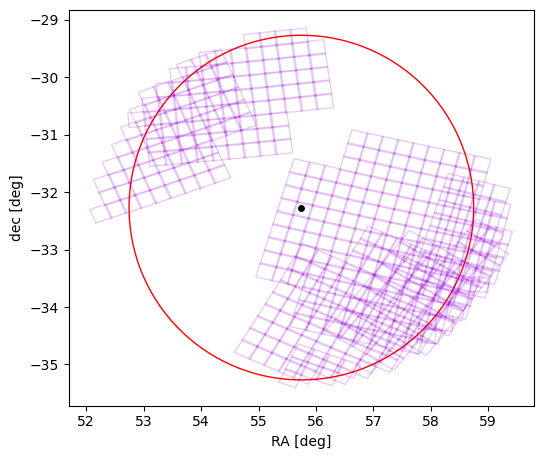

In [154]:
err_circle = plt.Circle((ra_deg, dec_deg), err_radius_deg, color='r',  fill=False)

fig, ax = plt.subplots(figsize=(6, 6))
ax.axes.set_aspect('equal')
ax.plot(ra_deg, dec_deg, 'o', ms=5, mew=0, color='black')
ax.add_patch(err_circle)
for i, row in images_table[images_table["lsst_band"] == "r"].iterrows():
    xvals, yvals = sregion_to_vertices(row['s_region'])
    ax.plot(xvals, yvals, lw=1, alpha=0.2, color='darkviolet')
ax.set_xlabel("RA [deg]")
ax.set_ylabel("dec [deg]")
plt.show()

Note that the error circle plot does not account properly for spherical to plane projections so it appears that some of the exposure were out of target.. They are right, it's the error circle to be wrong!

Now we plot a sample calexp. Each of the pink square above corresponds to an image like this:

[1/2] Downloading data..
[2/2] Plotting..


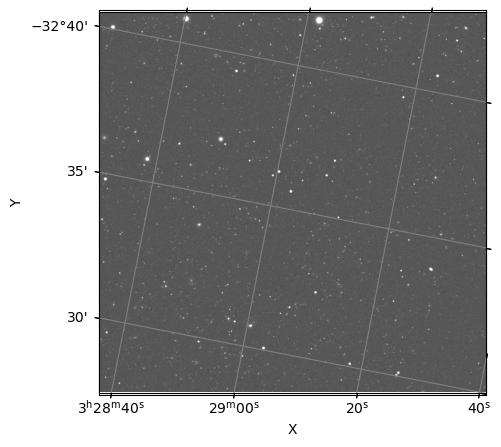

In [253]:
from pyvo.dal.adhoc import DatalinkResults
from astropy.io import fits
from astropy.wcs import WCS
import astropy.visualization as vis

IMG_INDEX = 0

print("[1/2] Downloading data..")
dl_results = DatalinkResults.from_result_url(
    images_table['access_url'][0],
    session=service._session,
)
image_url = dl_results['access_url'][IMG_INDEX]
image_hdr, image_data = fits.getdata(image_url, header=True)

print("[2/2] Plotting..")
fig, ax = plt.subplots(1, figsize=(5, 5))
plt.subplot(projection=WCS(img_hdr))
plt.imshow(img_data, cmap='gray', **{k: v for k, v in  zip(["vmin", "vmax"], zscale.get_limits(img_data))})
plt.axis('on'); ax.set_xticks([]); ax.set_yticks([]); plt.xlabel('X'); plt.ylabel('Y')
plt.grid(color='grey', ls='solid')
plt.show()

# Statistics

Let's gather some statistics on the number of calexp to be expected over a one week period. We run the code above a number of time, storing the resulting image tables at each iteration.

In [161]:
from tqdm.notebook import tqdm
import random
random.seed(0)

In [163]:
if you_have_time := False:
    N = 100
    results = []
    tlenght_days = 7
    tmin_mjd, tmax_mjd = visits_df["expMidptMJD"].min(), visits_df["expMidptMJD"].max() - tlenght_days
    
    for _ in tqdm(range(N)):
        trandom_mjd = random.uniform(tmin_mjd, tmax_mjd)
        start_mj, stop_mj = trandom_mjd, trandom_mjd + tlenght_days
        images_table = query_obs_stdomain(service, start_mj, stop_mj, ra_deg, dec_deg, err_radius_deg)
        results.append(((start_mj, stop_mj), images_table))

  0%|          | 0/100 [00:00<?, ?it/s]

Let's process the results into a table.

In [185]:
_rp = {
    "nvisits": [],
    "tstart": [],
    "tstop": [],
    **{f"nimgs_{band}": [] for band in "ugrizy"},
}
for ((tstart_mjd, tstop_mjd), table) in results:
    _rp["nvisits"].append(len(table["lsst_visit"].unique()))
    _rp["tstart"].append(tstart_mjd)
    _rp["tstop"].append(tstop_mjd)
    for band in "ugrizy":
        _rp[f"nimgs_{band}"].append(len(table[table["lsst_band"] == band]))

results_processed_df = pd.DataFrame(_rp)

In [186]:
results_processed_df

,nvisits,tstart,tstop,nimgs_u,nimgs_g,nimgs_r,nimgs_i,nimgs_z,nimgs_y
0,59,60959.245894,60966.245894,488,1239,898,1451,0,0
1,1,60346.220782,60353.220782,0,0,0,0,14,0
2,0,60052.493704,60059.493704,0,0,0,0,0,0
3,6,60511.028529,60518.028529,0,0,0,0,329,0
4,0,60317.807523,60324.807523,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
95,10,61023.514477,61030.514477,0,0,1056,0,0,0
96,0,59731.713414,59738.713414,0,0,0,0,0,0
97,14,60695.469420,60702.469420,441,283,561,0,0,0
98,0,60465.911437,60472.911437,0,0,0,0,0,0


First we can histogram the number of telescope visits we get over one week at our region.. The number of visits can get surprisingly large, I'm not sure why.

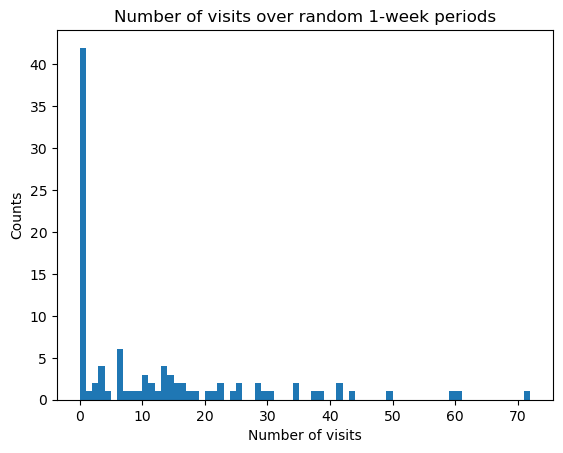

In [192]:
plt.hist(results_processed_df["nvisits"], bins=np.arange(0, results_processed_df["nvisits"].max() + 1))
plt.title("Number of visits over random 1-week periods")
plt.xlabel("Number of visits")
plt.ylabel("Counts")
plt.show()

Now let's plot the number of individual detector exposures in different bands.

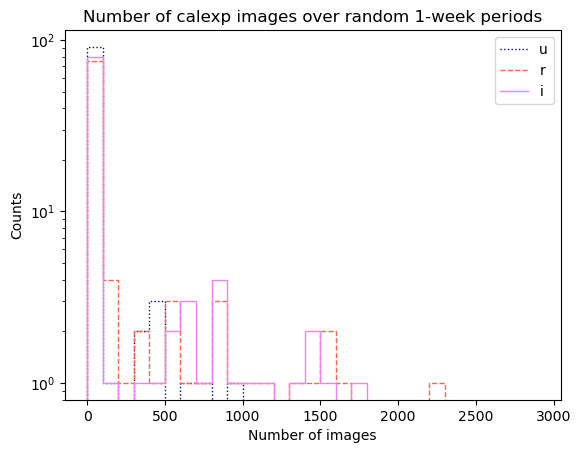

In [219]:
for c, ls, band in zip(
    ["navy", "tomato", "violet",],
    ["dotted", "dashed", "solid"],
    "uri"
):
    counts, bins = np.histogram(results_processed_df[f"nimgs_{band}"], bins=np.arange(0, 3000, 100))
    plt.stairs(counts, bins, label=f"{band}", color=c, ls=ls)
plt.title("Number of calexp images over random 1-week periods")
plt.xlabel("Number of images")
plt.ylabel("Counts")
plt.semilogy()
plt.legend()
plt.show()

So, most often we got 0 images. But the distribution seems to be midly exponential and goes all the way up to even 3000 images in a single band. Image count in the blue are generally less than images in the infrared, which are less than images in the red.
I'm curious about the week where we got the maximum image number.

In [216]:
_argmax = np.argmax(results_processed_df["nimgs_r"])
_, _table =  results[_argmax]

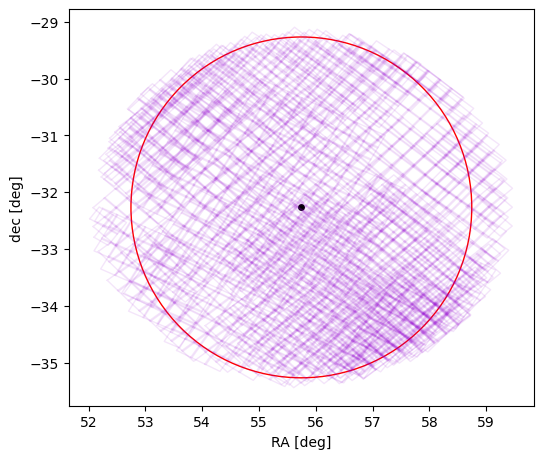

In [218]:
err_circle = plt.Circle((ra_deg, dec_deg), err_radius_deg, color='r',  fill=False)

fig, ax = plt.subplots(figsize=(6, 6))
ax.axes.set_aspect('equal')
ax.plot(ra_deg, dec_deg, 'o', ms=5, mew=0, color='black')
ax.add_patch(err_circle)
for i, row in _table[_table["lsst_band"] == "r"].iterrows():
    xvals, yvals = sregion_to_vertices(row['s_region'])
    ax.plot(xvals, yvals, lw=1, alpha=0.1, color='darkviolet')
ax.set_xlabel("RA [deg]")
ax.set_ylabel("dec [deg]")
plt.show()